<a href="https://colab.research.google.com/github/arina19-2000/unimi/blob/main/tesi/adult_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab


In [17]:
import numpy as np
import pandas as pd
from scipy import stats
df_adults = pd.read_excel('dfa.xlsx')

In [18]:
df_adults

,Unnamed: 0,adopt_age,origin_region,scolarizzato_paese_origine_italia_inclusa,presenza_certificazione_sensi_l170_2010,difficoltà_rendimentoapprendimento_spinto_cambiare_tipologia_indirizzo_scuola_secondaria_secondo_grado_superiore,fatto_anni_istruzione_universitaria_afam_senza_conseguire_titolo,già_indipendenza_economica,attualmente_lavora,qual_titolo_studio_massimo_conseguito_madre,...,school_experience_primary_encoded,prima_classe_frequenza_scuola,origin_region.1,dovuto_ripetere_anni_padre,dovuto_ripetere_anni_madre,dovuto_ripetere_anni_superiore,adozione_int,valutazione_voto60,valutazione_voto100,qual_titolo_studio_massimo_conseguito
0,2,1,78,0.0,0.0,NaN,NaN,1.0,1.0,1.0,...,3.0,4.0,78,NaN,NaN,NaN,0,0,0,5.0
1,4,5,78,1.0,1.0,0.0,0.0,0.0,0.0,5.0,...,3.0,2.0,78,0.0,1.0,1.0,0,0,76,3.0
2,5,15,118,0.0,1.0,0.0,0.0,0.0,0.0,6.0,...,3.0,2.0,118,0.0,0.0,0.0,1,45,0,3.0
3,6,0,78,0.0,0.0,NaN,NaN,0.0,1.0,5.0,...,2.0,1.0,78,0.0,0.0,NaN,0,0,0,6.0
4,7,3,78,1.0,0.0,0.0,0.0,1.0,1.0,3.0,...,2.0,2.0,78,0.0,0.0,0.0,0,0,70,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,772,6,63,0.0,0.0,NaN,NaN,NaN,1.0,6.0,...,1.0,3.0,63,0.0,1.0,NaN,1,0,0,1.0
369,773,7,118,0.0,0.0,0.0,0.0,0.0,1.0,6.0,...,3.0,4.0,118,0.0,1.0,1.0,1,60,0,3.0
370,778,6,7,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,2.0,2.0,7,1.0,0.0,0.0,1,74,0,3.0
371,783,2,118,NaN,0.0,NaN,NaN,0.0,0.0,NaN,...,2.0,2.0,118,NaN,NaN,NaN,1,0,0,5.0


In [19]:
df_adults['qual_titolo_studio_massimo_conseguito'] = df_adults['qual_titolo_studio_massimo_conseguito'].replace({7: 6, 8: 6, 1: 2,  0.5: 2})

1. Nessun titolo/Licenza elementare o frequentazione della sola scuola primaria
2. Licenza di scuola secondaria di primo grado (precedentemente denominata licenza media inferiore)
3. Titolo di diploma di qualifica professionale che non permette l’accesso all’università (3 o 4 anni)
4. Titolo di scuola secondaria di secondo grado (denominata precedentemente scuola superiore) che permette l’iscrizione all’università (5 anni)
5. Titolo post-secondario non terziario (IFTS)
6. Titolo di studio universitario
7. Titolo di studio post-universitario (Master, Scuola di perfezionamento, ecc.)
8. Dottorato di ricerca

In [20]:
df_adults['qual_titolo_studio_massimo_conseguito'].value_counts()

,count
qual_titolo_studio_massimo_conseguito,
3.0,226
2.0,85
5.0,43
4.0,10
6.0,9


In [21]:
df_adults["qual_titolo_studio_massimo_conseguito"] = df_adults["qual_titolo_studio_massimo_conseguito"].astype(int)

In [22]:
df_adults = df_adults.drop(columns=['Unnamed: 0','origin_region.1'])
df_adults = df_adults[df_adults['qual_titolo_studio_massimo_conseguito'] != 0]

In [23]:
!pip install ydata_profiling

In [24]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df_adults, title="Profiling Report")
# profile.to_widgets()

In [25]:
from sklearn.preprocessing import StandardScaler

target_variable = "qual_titolo_studio_massimo_conseguito"
numeric_vars = ["adopt_age", "valutazione_voto60", "valutazione_voto100", "prima_classe_frequenza_scuola"]

numeric_vars = [col for col in numeric_vars if col in df_adults.columns]
categorical_vars = [col for col in df_adults.columns if col not in numeric_vars + [target_variable]]
df_cleaned = df_adults.dropna(axis=1, thresh=len(df_adults) * 0.7).copy()

for col in numeric_vars:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

if numeric_vars:
    scaler = StandardScaler()
    df_cleaned[numeric_vars] = scaler.fit_transform(df_cleaned[numeric_vars])

for col in categorical_vars:
    if col in df_cleaned.columns:
        if df_cleaned[col].dropna().shape[0] > 0:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].dropna().mode()[0])

print("Missing values:\n", df_cleaned.isnull().sum().sum())

Missing values:
 0


In [26]:
from scipy.stats import zscore

target_column = "qual_titolo_studio_massimo_conseguito"

numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target_column]
z_scores = df_cleaned[numeric_cols].apply(zscore, nan_policy='omit')

outlier_rows = df_cleaned[(z_scores > 3).any(axis=1) | (z_scores < -3).any(axis=1)]

for col in numeric_cols:
    upper_bound = df_cleaned[col].mean() + 3 * df_cleaned[col].std()
    lower_bound = df_cleaned[col].mean() - 3 * df_cleaned[col].std()
    outlier_rows.loc[:, col] =outlier_rows[col].clip(lower=lower_bound, upper=upper_bound)
df_cleaned.update(outlier_rows)

In [27]:
outliers = (z_scores > 3) | (z_scores < -3)
outlier_counts = outliers.sum()

# Summarize outliers
outlier_summary = pd.DataFrame({
    "Column": numeric_cols,
    "Outlier Count": outlier_counts
}).sort_values(by="Outlier Count", ascending=False)
print(outlier_summary)

                                                                                               Column  \
dovuto_ripetere_anni_padre                                                 dovuto_ripetere_anni_padre   
valutazione_voto60                                                                 valutazione_voto60   
dovuto_ripetere_anni_madre                                                 dovuto_ripetere_anni_madre   
adopt_age                                                                                   adopt_age   
prima_classe_frequenza_scuola                                           prima_classe_frequenza_scuola   
fatto_esperienze_allestero                                                 fatto_esperienze_allestero   
adozione_int                                                                             adozione_int   
school_experience_primary_encoded                                   school_experience_primary_encoded   
school_experience_secondary_encoded                    

In [28]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

def gauss_markov_assumptions(X, y):

    # 1. Independence of Errors: Durbin-Watson test
    X_with_intercept = sm.add_constant(X)
    ols_model = sm.OLS(y, X_with_intercept).fit()
    dw_statistic = sm.stats.durbin_watson(ols_model.resid)
    print(f"Durbin-Watson statistic: {dw_statistic}")


    # 2. Breusch-Pagan Test for homoscedasticity
    bp_test = sms.het_breuschpagan(ols_model.resid, ols_model.model.exog)
    print(f"Breusch-Pagan Test p-value: {bp_test[1]}")

    # 3. VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVariance Inflation Factors (VIF):")
    print(vif_data)

X = df_cleaned.drop(columns=['qual_titolo_studio_massimo_conseguito'])
y = df_cleaned['qual_titolo_studio_massimo_conseguito']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
gauss_markov_assumptions(X_train, y_train)

Durbin-Watson statistic: 2.0296394222692977
Breusch-Pagan Test p-value: 5.651868221458223e-19

Variance Inflation Factors (VIF):
                                              feature        VIF
0                                           adopt_age   1.709128
1                                       origin_region  10.399372
2           scolarizzato_paese_origine_italia_inclusa   2.321298
3             presenza_certificazione_sensi_l170_2010   1.339986
4                          già_indipendenza_economica   2.380629
5                                  attualmente_lavora   3.050332
6         qual_titolo_studio_massimo_conseguito_madre   9.998712
7         qual_titolo_studio_massimo_conseguito_padre   8.416406
8   presenza_patologie_certificate_sensi_104_comma...   1.231764
9         descrizione_nucleo_familiare_figlio_encoded   5.714273
10                                  sibling_adopt_yes   1.577394
11                         fatto_esperienze_allestero   1.419674
12                        

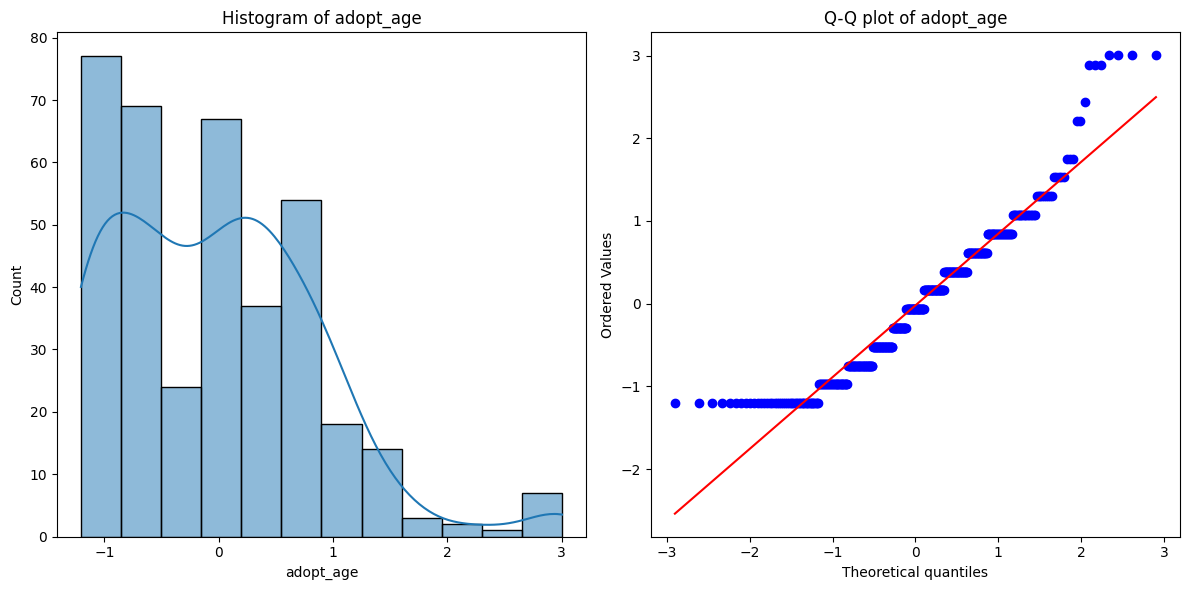

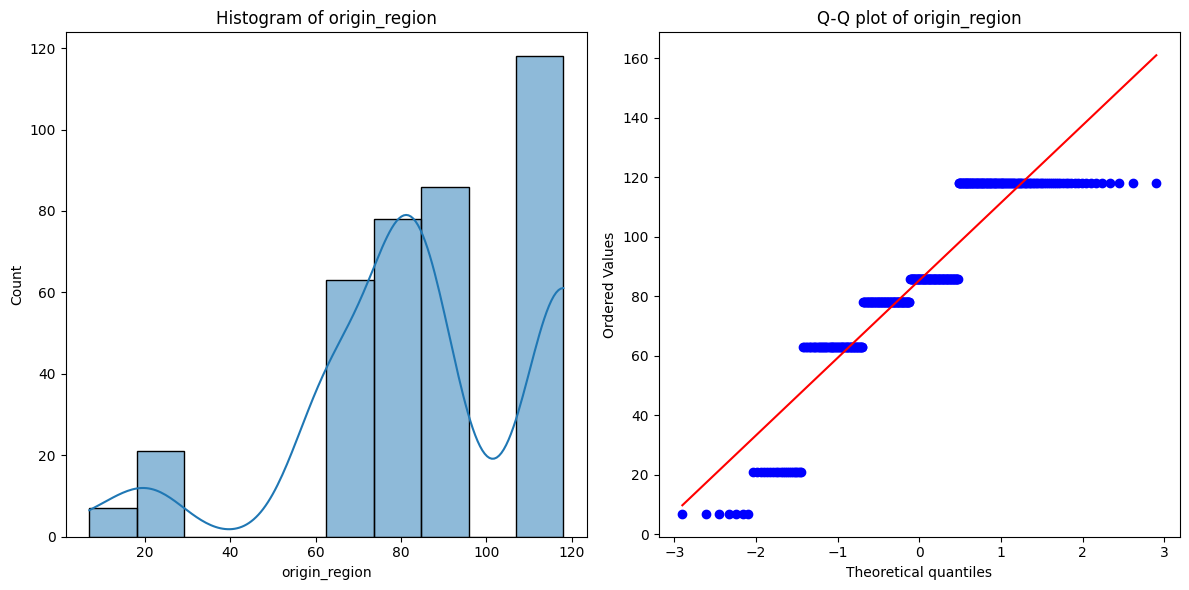

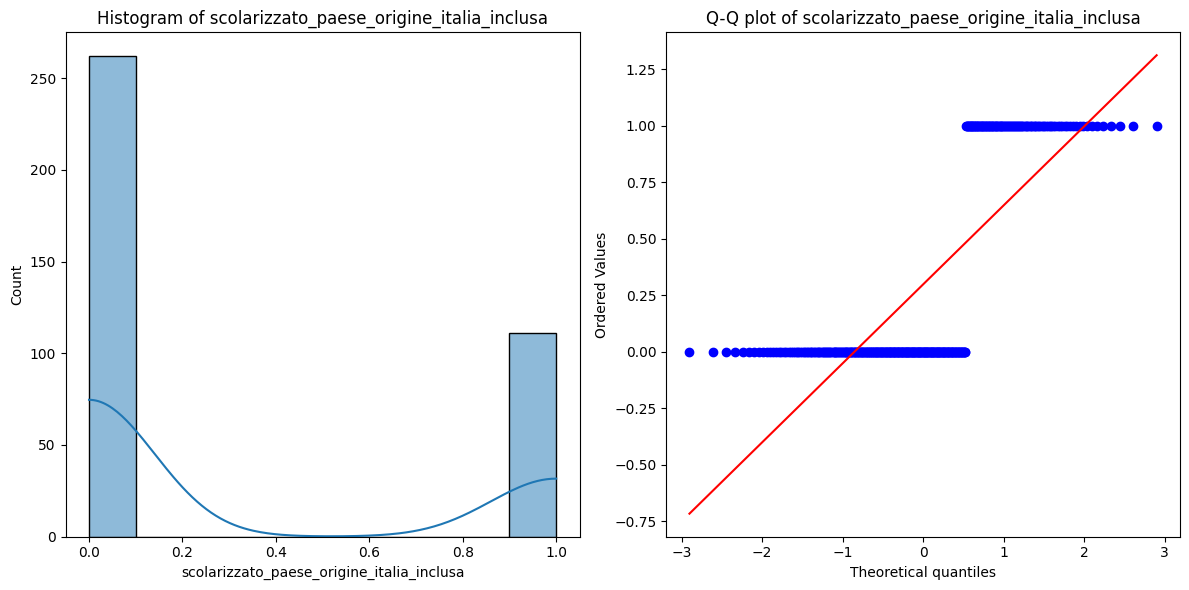

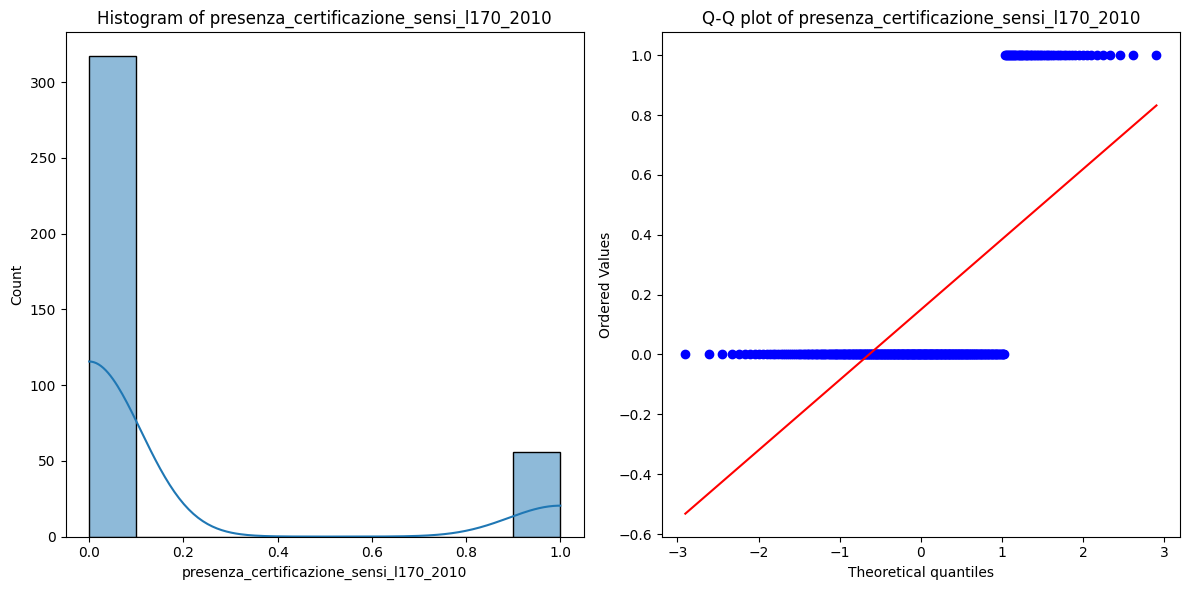

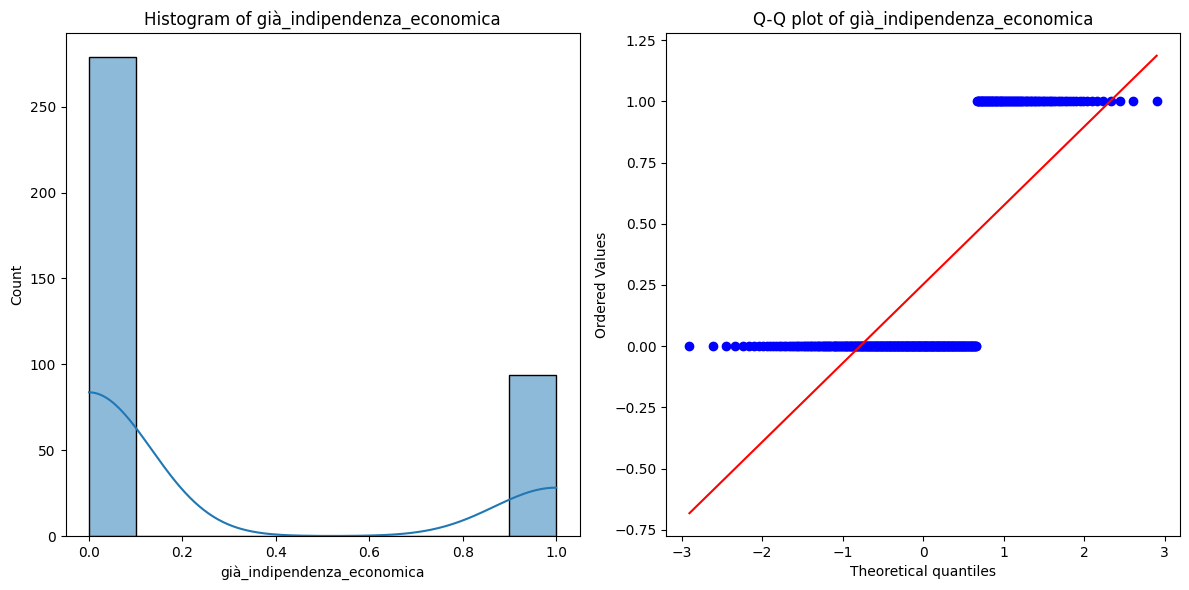

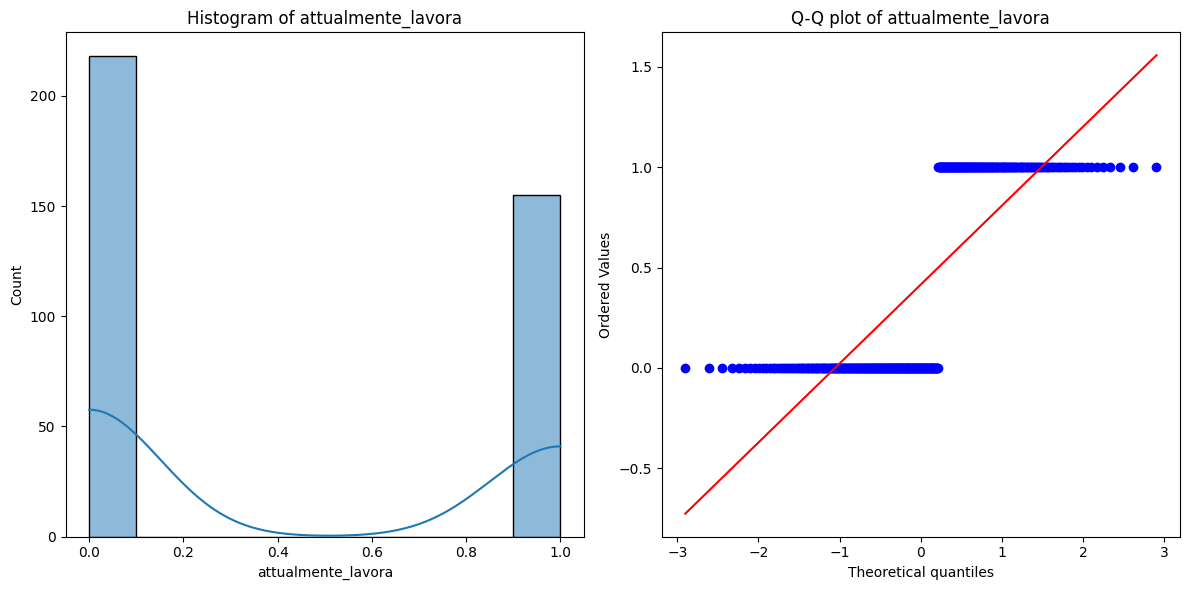

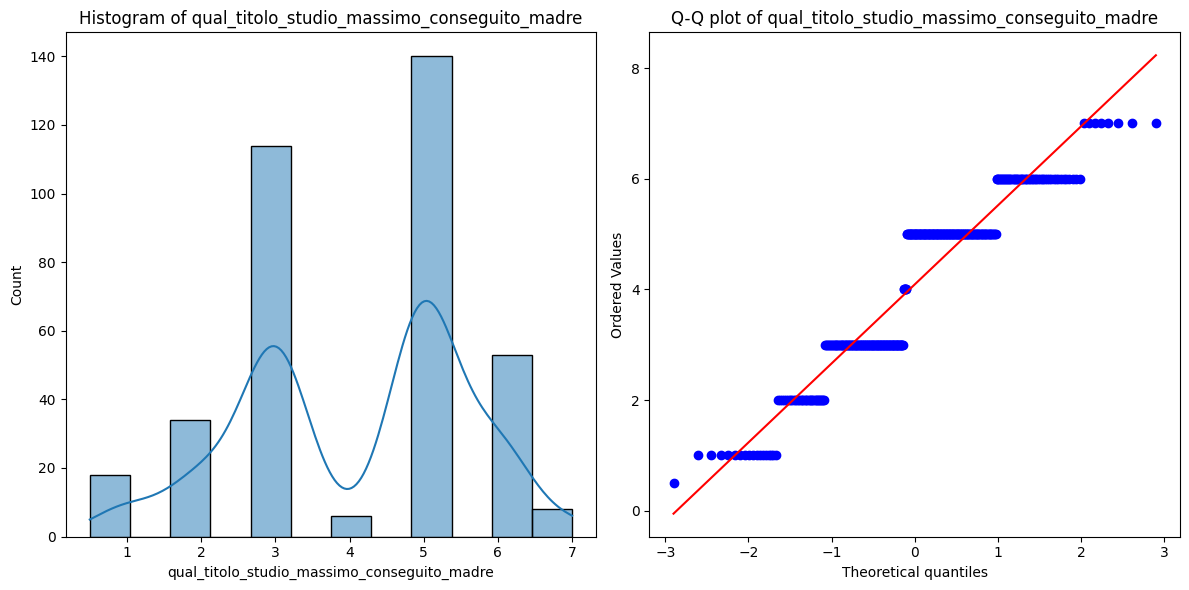

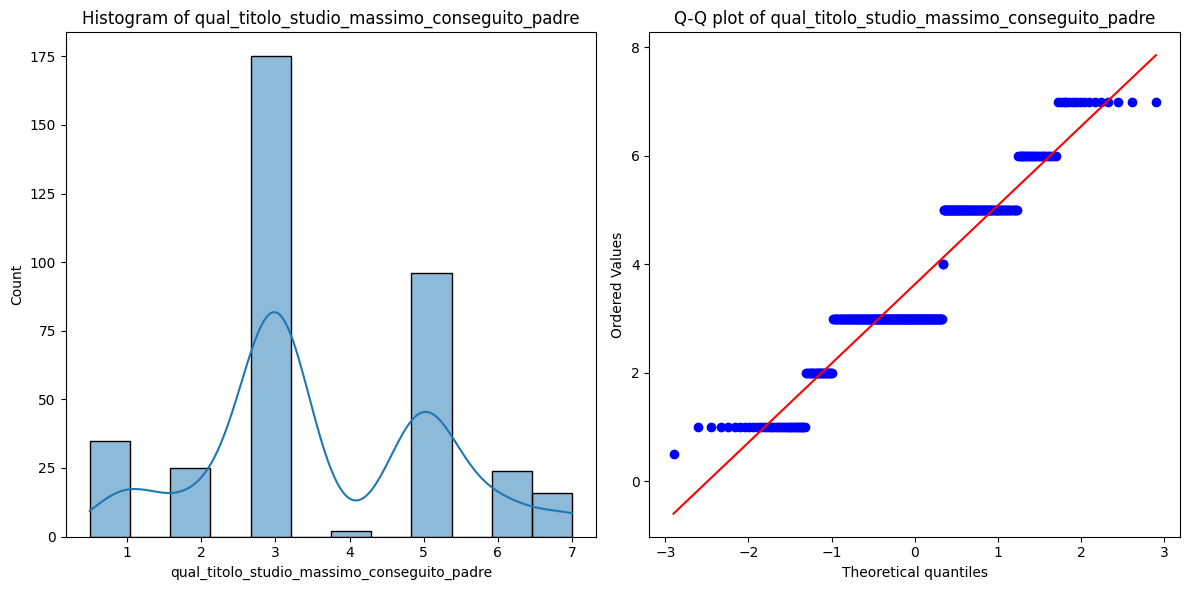

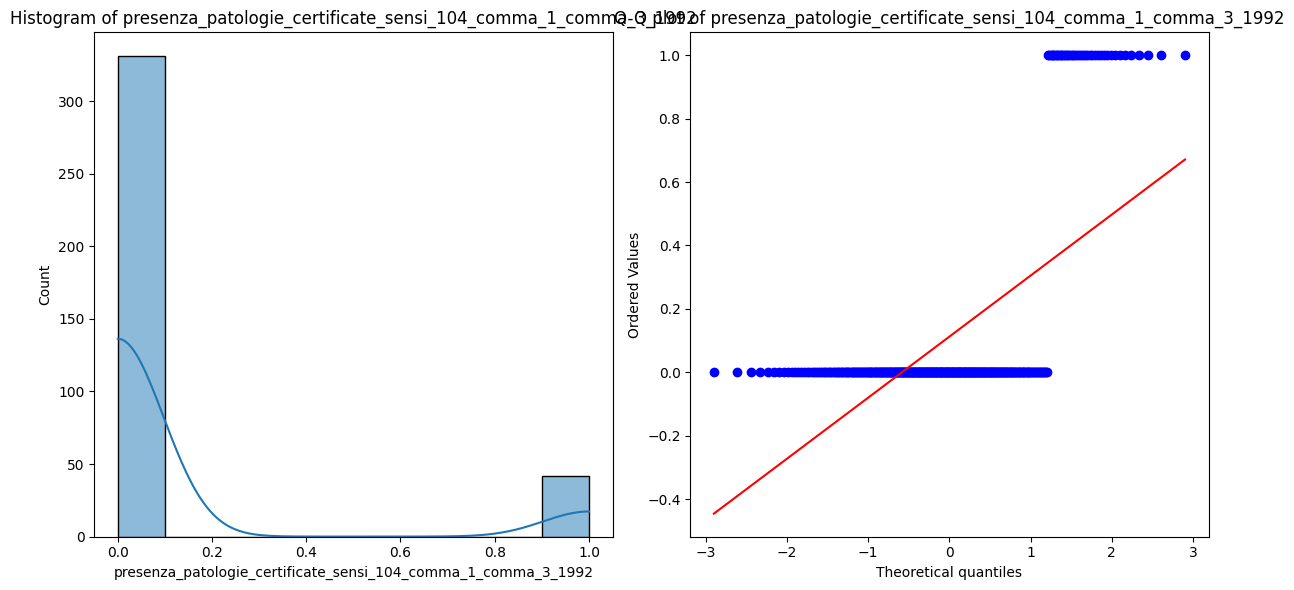

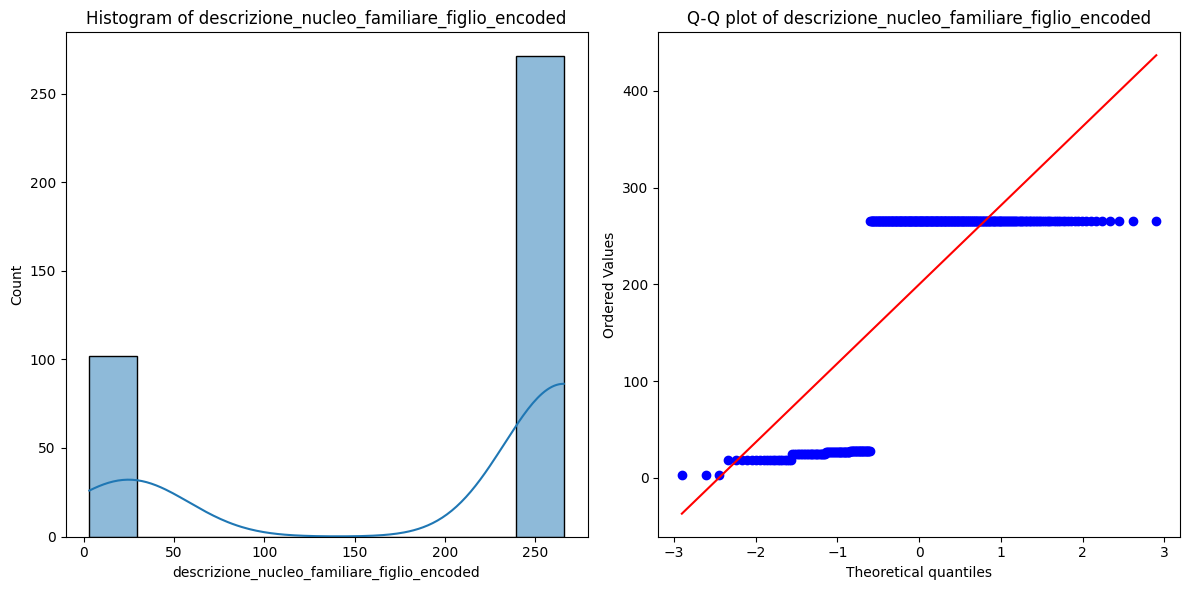

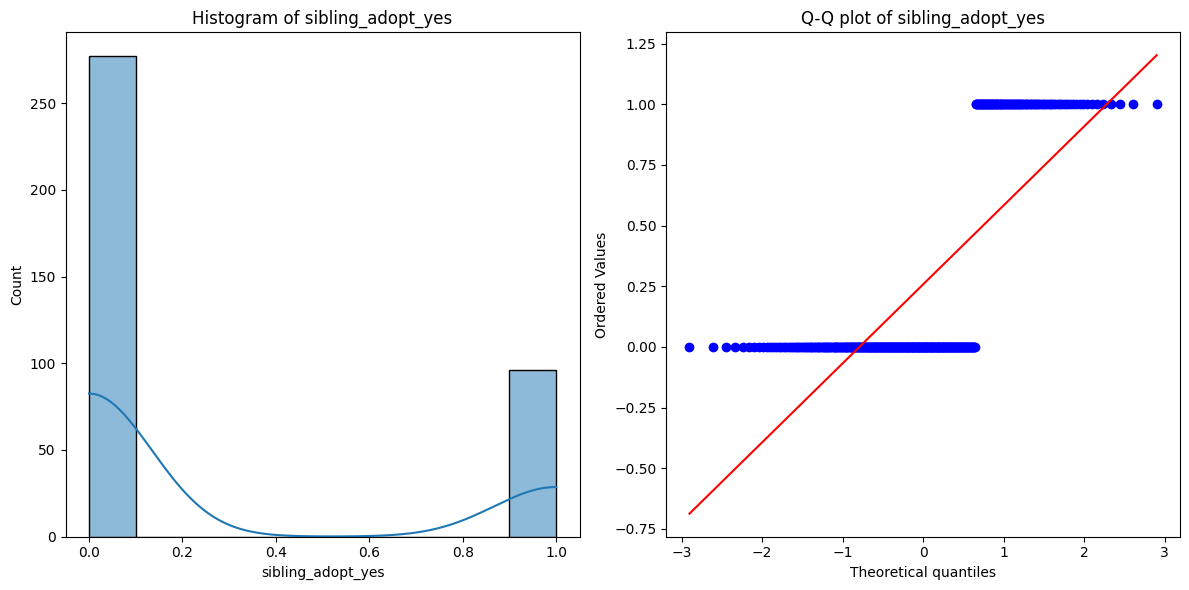

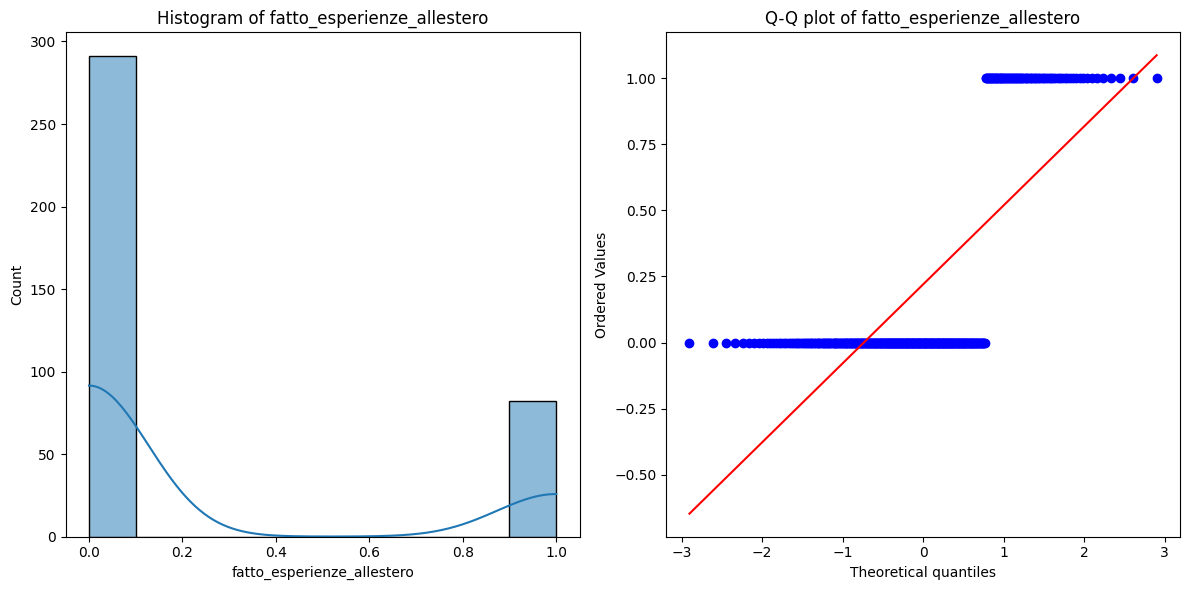

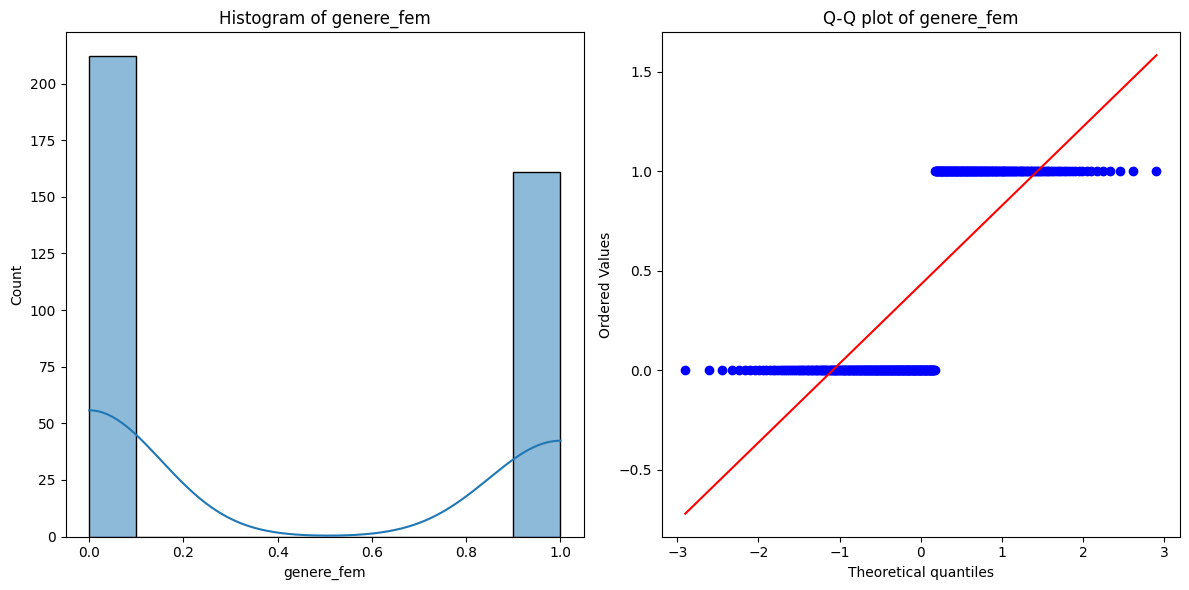

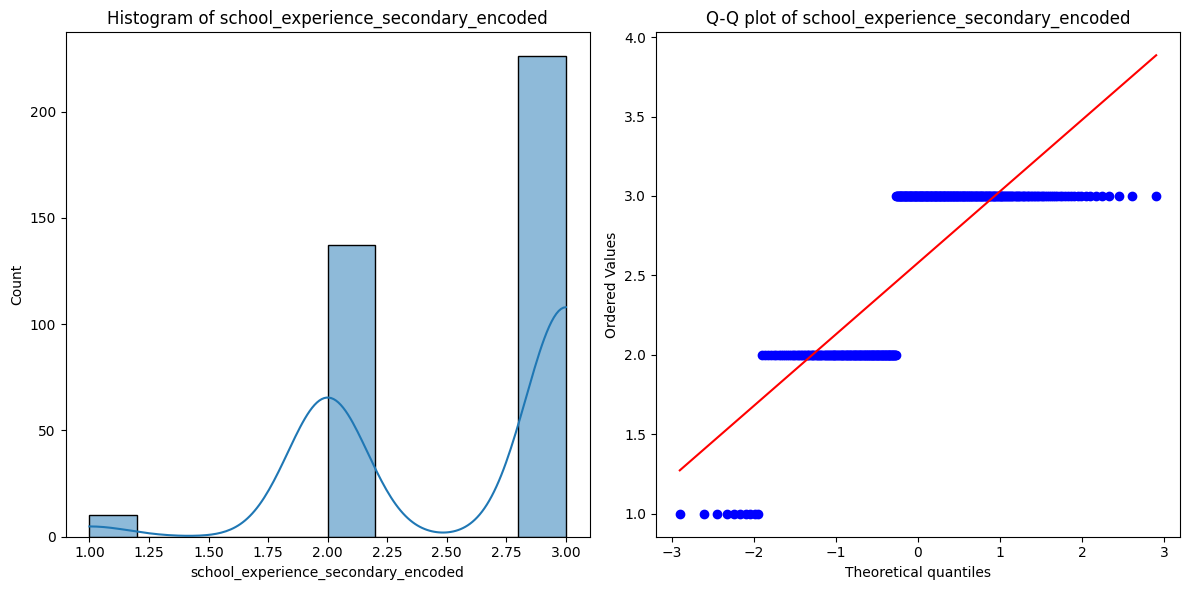

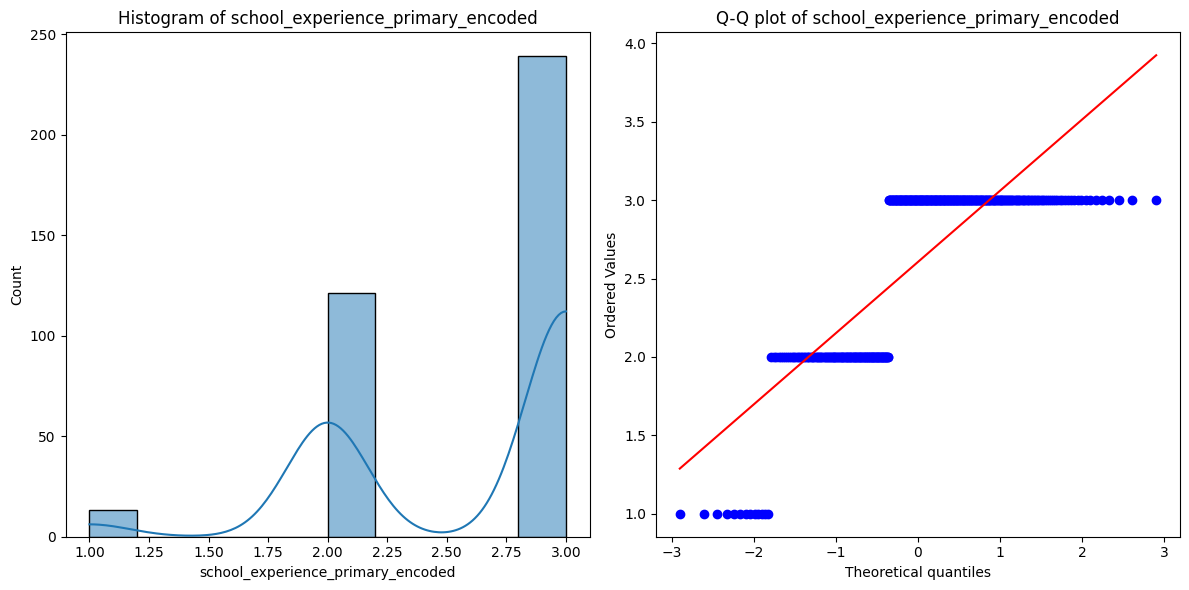

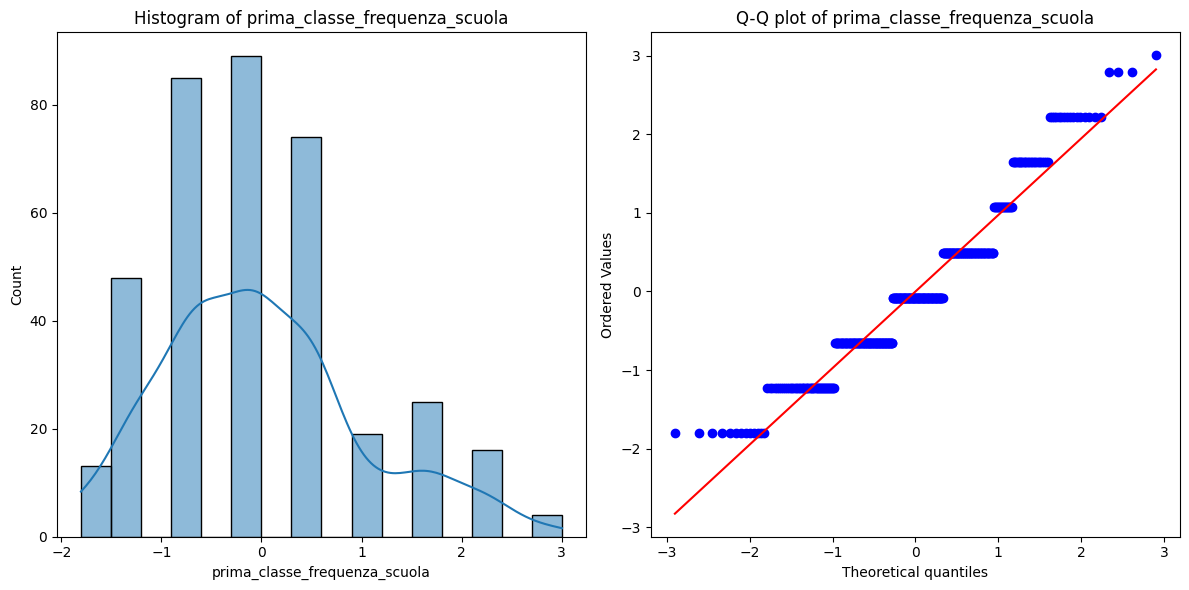

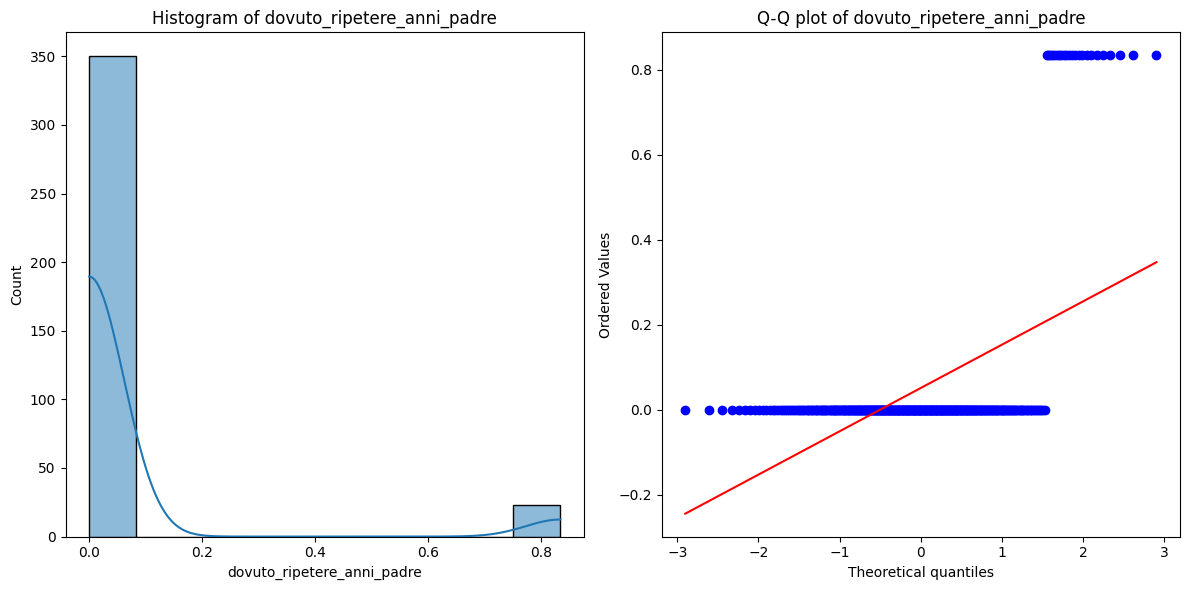

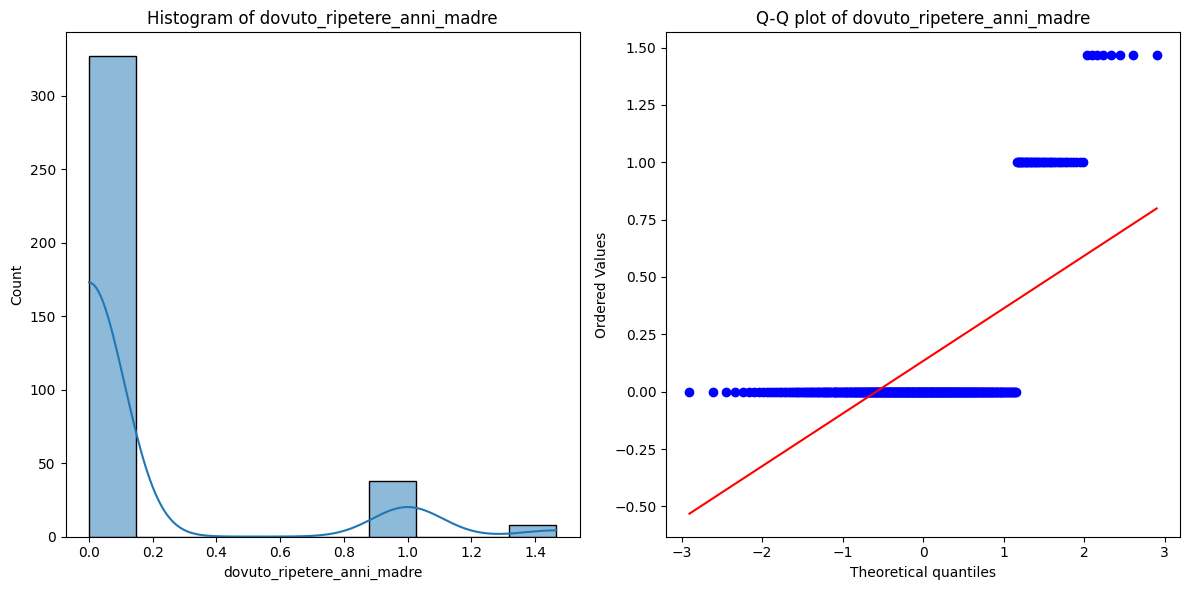

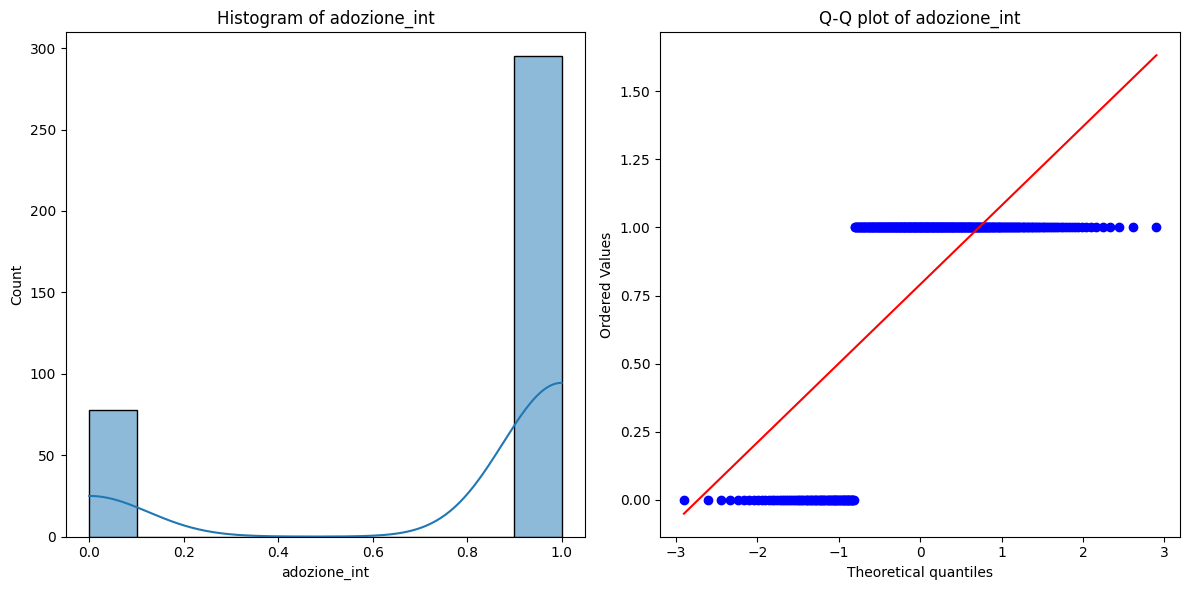

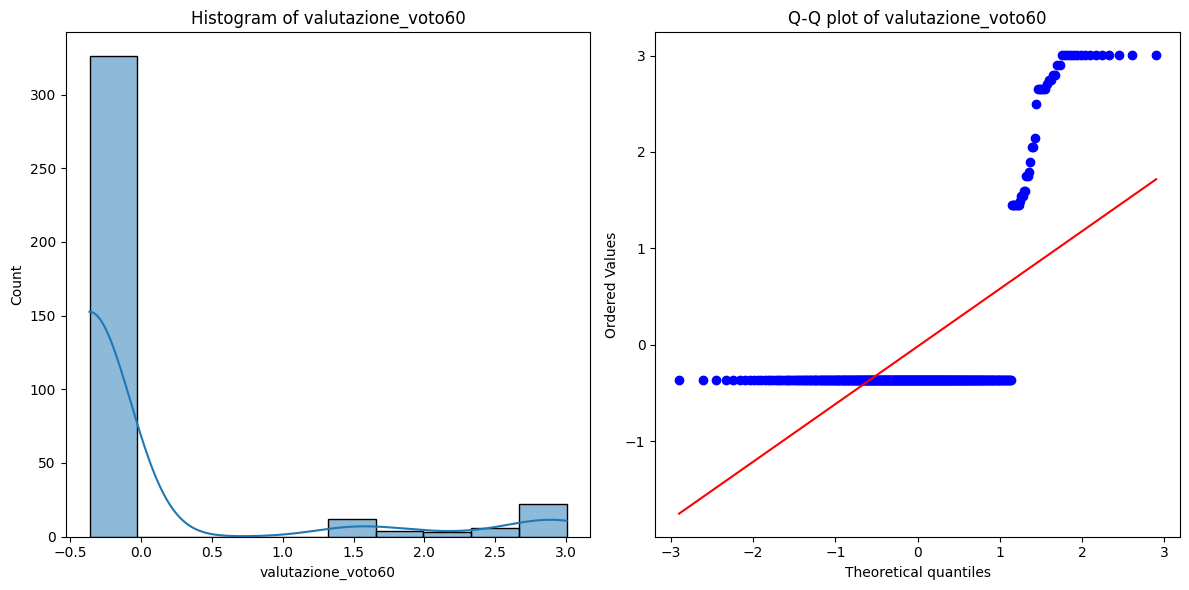

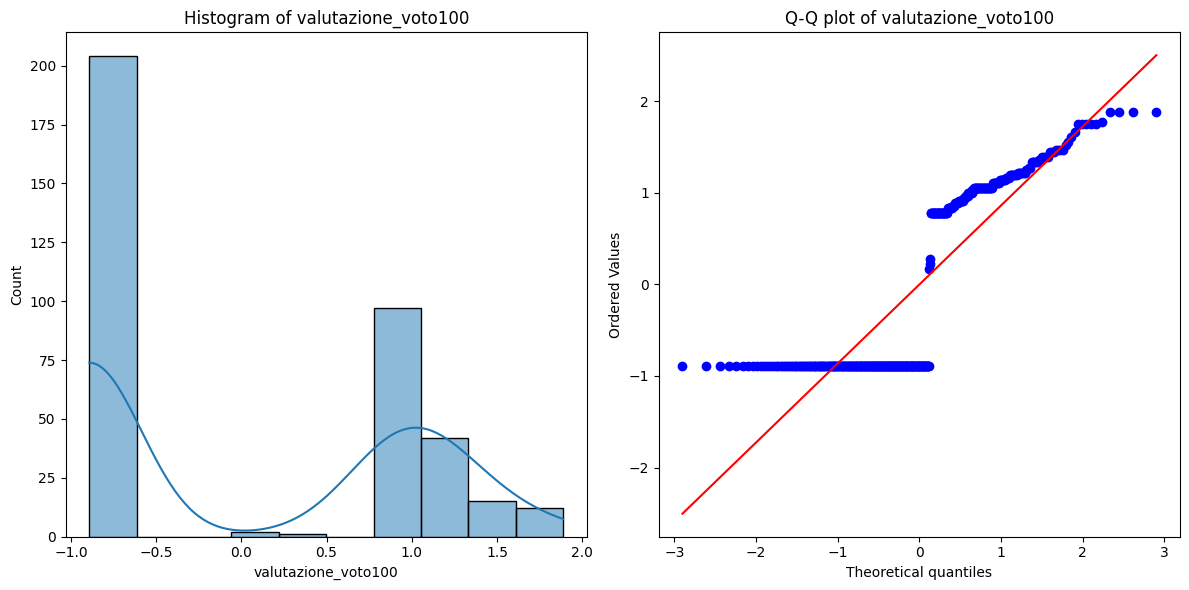

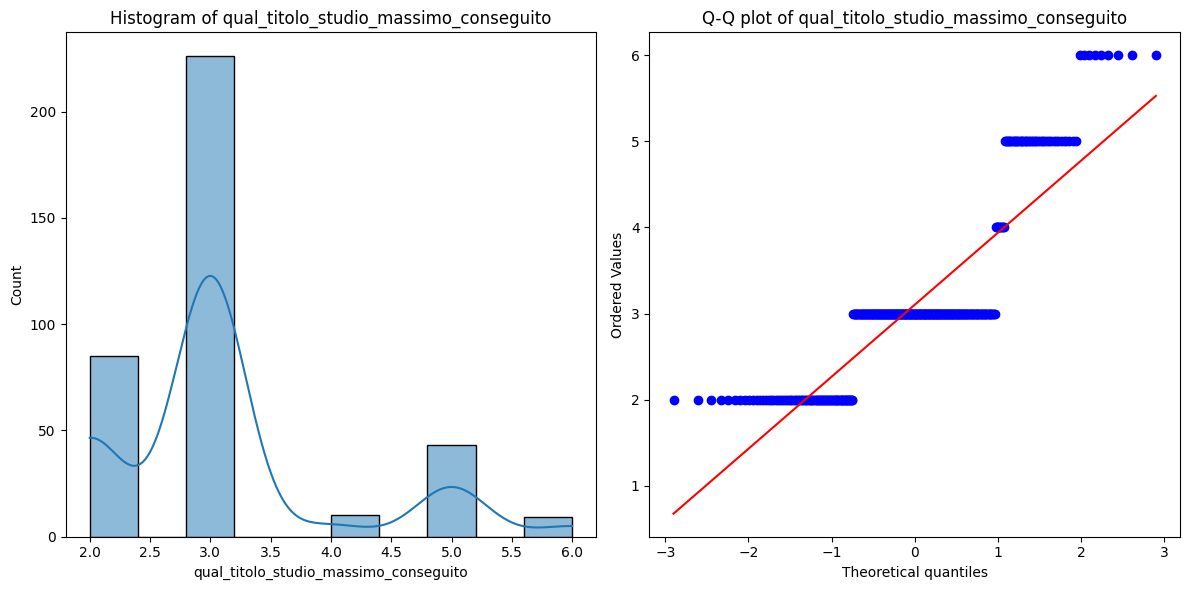

In [29]:
for col in df_cleaned.columns:
    # Histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df_cleaned[col], dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {col}')

    plt.tight_layout()
    plt.show()


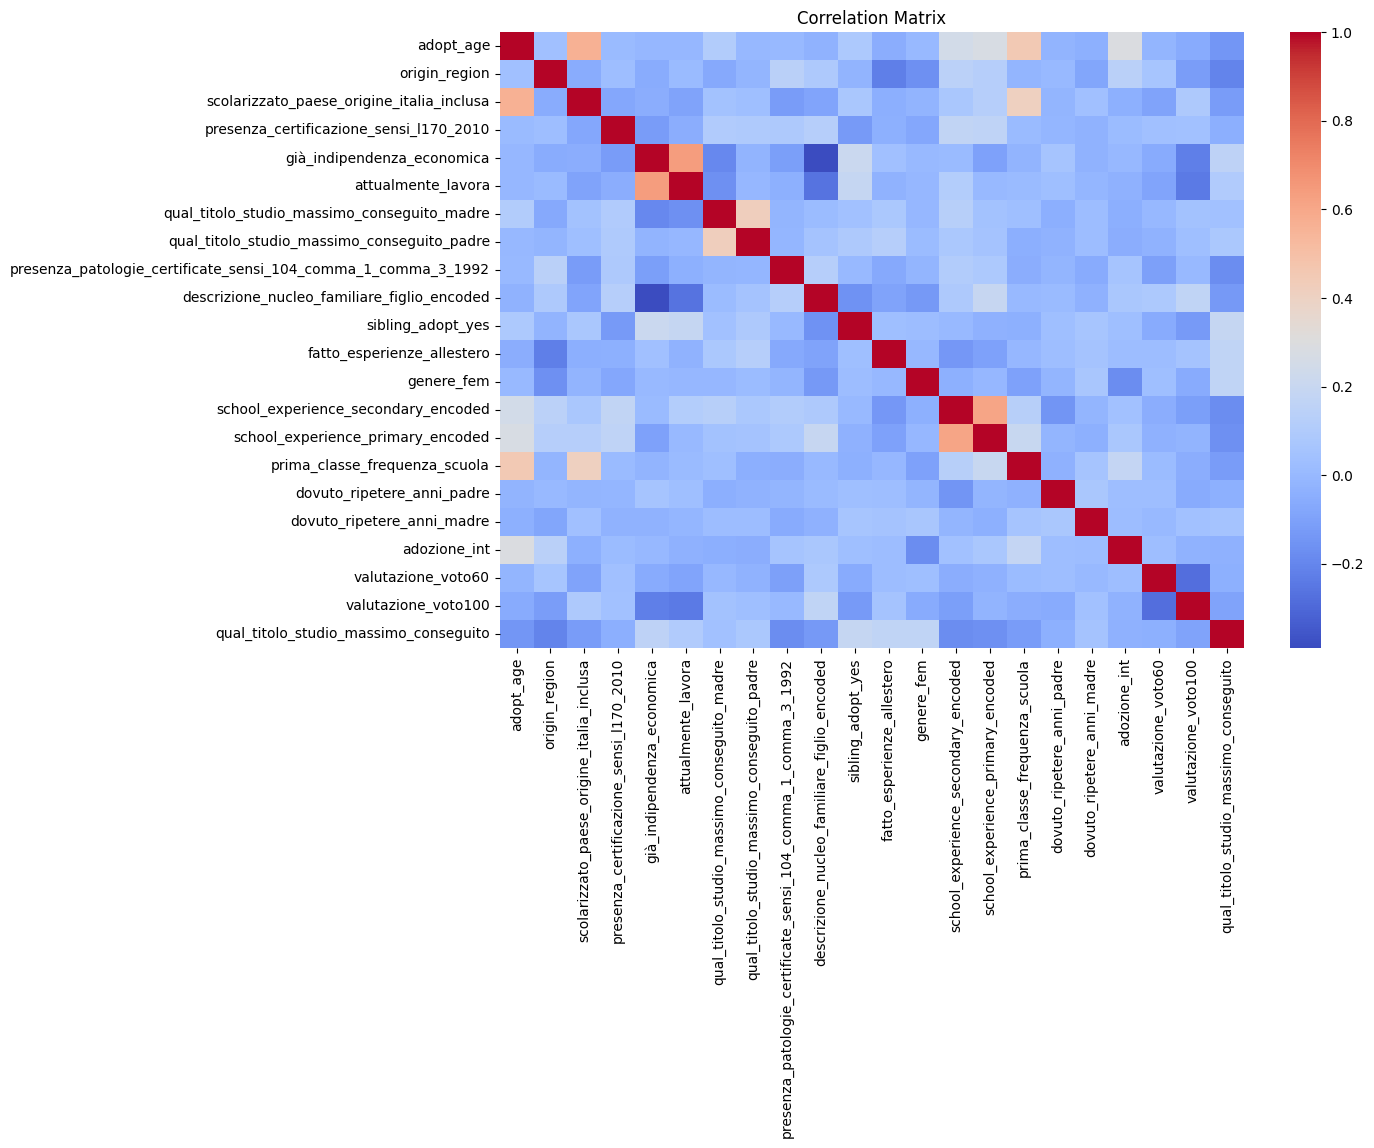

In [30]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()


In [31]:
high_vif_columns = ["school_experience_secondary_encoded",
                    "qual_titolo_studio_massimo_conseguito_padre",
                    "origin_region",'descrizione_nucleo_familiare_figlio_encoded','school_experience_primary_encoded']

df_cleaned = df_cleaned.drop(columns=high_vif_columns)


In [32]:
X = df_cleaned.drop(columns=['qual_titolo_studio_massimo_conseguito'])
y = df_cleaned['qual_titolo_studio_massimo_conseguito']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gauss_markov_assumptions(X_train, y_train)

Durbin-Watson statistic: 1.8863694884025273
Breusch-Pagan Test p-value: 4.536003415108844e-20

Variance Inflation Factors (VIF):
                                              feature       VIF
0                                           adopt_age  1.699428
1           scolarizzato_paese_origine_italia_inclusa  2.107921
2             presenza_certificazione_sensi_l170_2010  1.187576
3                          già_indipendenza_economica  2.385568
4                                  attualmente_lavora  2.837508
5         qual_titolo_studio_massimo_conseguito_madre  5.190143
6   presenza_patologie_certificate_sensi_104_comma...  1.167010
7                                   sibling_adopt_yes  1.554431
8                          fatto_esperienze_allestero  1.342341
9                                          genere_fem  1.716025
10                      prima_classe_frequenza_scuola  1.481551
11                         dovuto_ripetere_anni_padre  1.089624
12                         dovuto_ripet

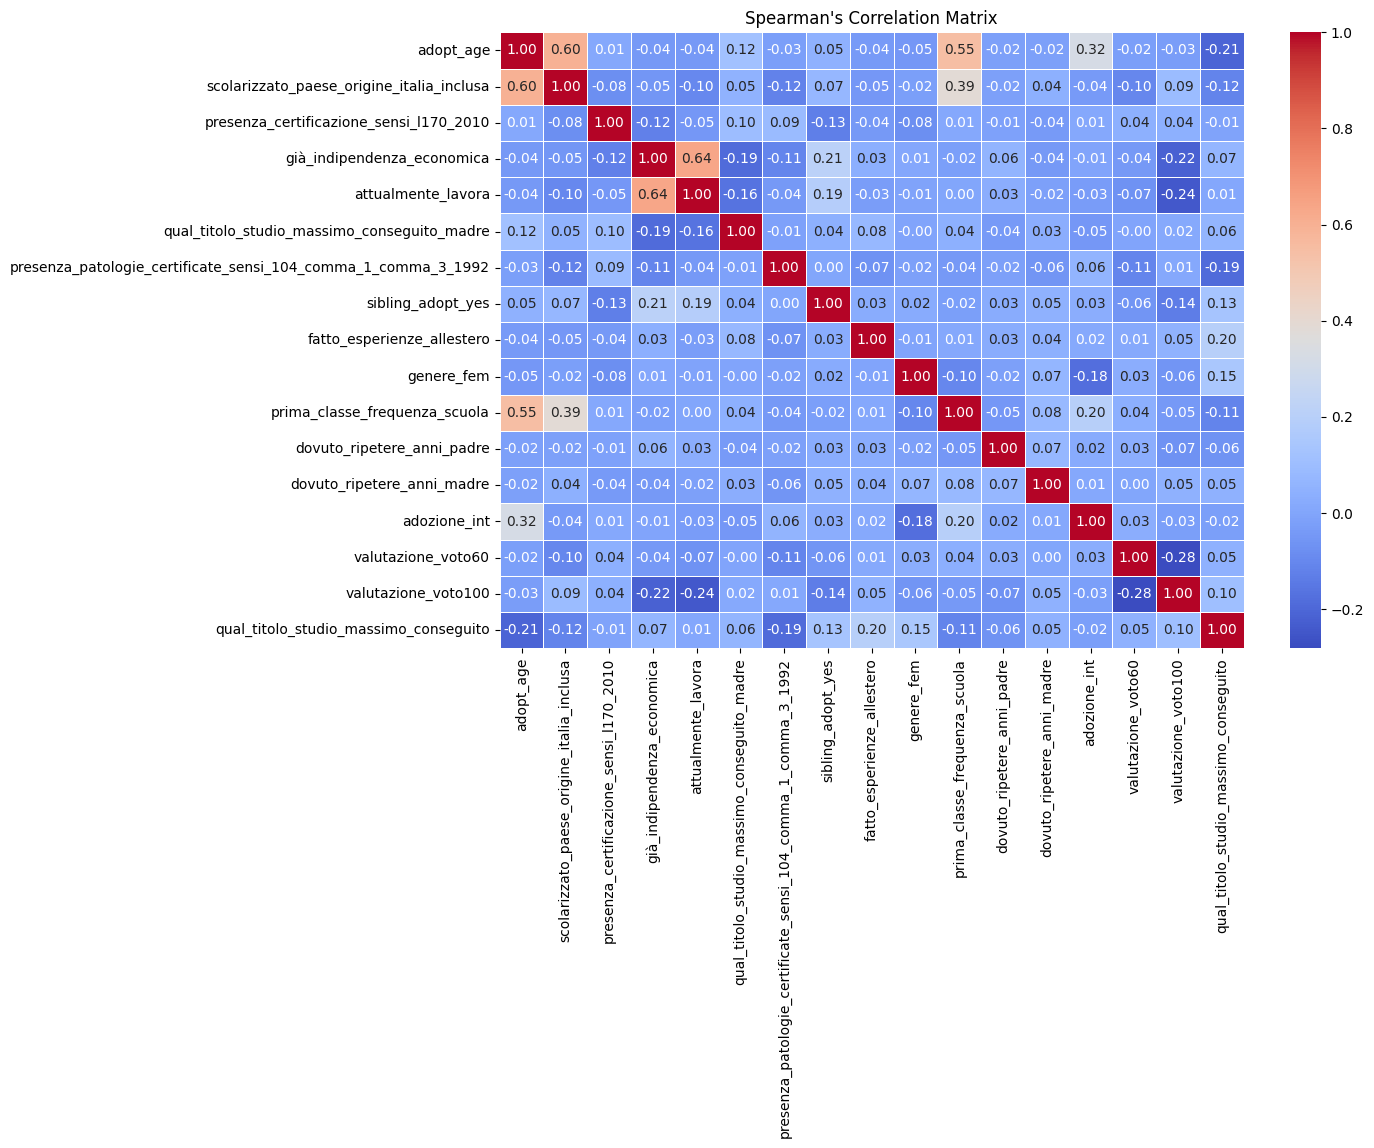

In [33]:
spearman_corr = df_cleaned.corr(method="spearman")

# Plot Spearman's correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Spearman's Correlation Matrix")
plt.show()

## Stat Models

In [34]:
from scipy.stats import chi2_contingency

categorical_vars = [col for col in categorical_vars if col in df_cleaned.columns]
for cat_var in categorical_vars:
    try:
        contingency_table = pd.crosstab(df_cleaned[cat_var], df_cleaned[target_variable])
        stat, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-Square Test for Independence between {target_variable} and {cat_var}:")
        print(f"Statistic: {stat}, p-value: {p_value}, Degrees of Freedom: {dof}\n")
    except KeyError:
        print(f"Skipping {cat_var} - column not found in df_cleaned.")


Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and scolarizzato_paese_origine_italia_inclusa:
Statistic: 6.9821361817485466, p-value: 0.13683526317624276, Degrees of Freedom: 4

Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and presenza_certificazione_sensi_l170_2010:
Statistic: 5.309789187459172, p-value: 0.2569619293541882, Degrees of Freedom: 4

Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and già_indipendenza_economica:
Statistic: 35.926257125106034, p-value: 2.996555853114448e-07, Degrees of Freedom: 4

Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and attualmente_lavora:
Statistic: 35.66564106272275, p-value: 3.390157024690225e-07, Degrees of Freedom: 4

Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and qual_titolo_studio_massimo_conseguito_madre:
Statistic: 27.954762955703757, p-value: 0.4668468068087901, Degrees of 

In [35]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.0 MB/s eta 0:00:00


In [36]:
for cat_var in categorical_vars:
    try:
        groups = [df_cleaned[df_cleaned[cat_var] == val][target_variable].dropna()
                  for val in df_cleaned[cat_var].unique()]

        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            kruskal_stat, kruskal_p_value = stats.kruskal(*groups)

            print(f"Kruskal-Wallis test result for {target_variable} by {cat_var}:")
            print(f"Statistic: {kruskal_stat}, p-value: {kruskal_p_value}\n")
        else:
            print(f"Skipping {cat_var} - Not enough valid groups for Kruskal-Wallis test.")

    except KeyError:
        print(f"Skipping {cat_var} - column not found in df_cleaned.")

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by scolarizzato_paese_origine_italia_inclusa:
Statistic: 5.010939966073143, p-value: 0.02518762767895624

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by presenza_certificazione_sensi_l170_2010:
Statistic: 0.042787315498427854, p-value: 0.8361262642186363

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by già_indipendenza_economica:
Statistic: 1.668926410248526, p-value: 0.19640239467083426

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by attualmente_lavora:
Statistic: 0.010979568572289922, p-value: 0.9165476534185294

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by qual_titolo_studio_massimo_conseguito_madre:
Statistic: 6.497310056255084, p-value: 0.4830220450878695

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992:
Statistic: 13.06673687339

In [37]:
pip install imbalanced-learn


In [38]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y.values.ravel(), test_size=0.2, random_state=42, stratify=y.values.ravel()
# )

In [39]:
y_train.value_counts()

,count
qual_titolo_studio_massimo_conseguito,
3,181
2,68
5,35
4,8
6,6


In [40]:
from imblearn.combine import SMOTETomek

class_counts = pd.Series(y_train).value_counts()

smote_tomek = SMOTETomek(sampling_strategy="not majority", random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

class_counts_resampled = pd.Series(y_resampled).value_counts()
print("Class Distribution After Resampling:\n", class_counts_resampled)
resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
resampled_df["qual_titolo_studio_massimo_conseguito"] = y_resampled
class_counts_smote_tomek = pd.Series(y_train).value_counts().sort_index()

Class Distribution After Resampling:
 qual_titolo_studio_massimo_conseguito
5    181
4    181
6    181
3    180
2    180
Name: count, dtype: int64


In [41]:
X_train, y_train = X_resampled, y_resampled

In [42]:
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.miscmodels.ordinal_model import OrderedModel

formula = '''
qual_titolo_studio_massimo_conseguito ~
    adopt_age +
    scolarizzato_paese_origine_italia_inclusa +
    presenza_certificazione_sensi_l170_2010 +
    qual_titolo_studio_massimo_conseguito_madre +
    presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 +
    sibling_adopt_yes +
    fatto_esperienze_allestero +
    genere_fem +
    prima_classe_frequenza_scuola +
    dovuto_ripetere_anni_padre +
    dovuto_ripetere_anni_madre +
    adozione_int +
    valutazione_voto60 +
    valutazione_voto100 - 1
'''

selected_features = [
    "adopt_age",
    "scolarizzato_paese_origine_italia_inclusa",
    "presenza_certificazione_sensi_l170_2010",
    "qual_titolo_studio_massimo_conseguito_madre",
    # "presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992",
    "sibling_adopt_yes",
    "fatto_esperienze_allestero",
    "genere_fem",
    "dovuto_ripetere_anni_madre",
    "adozione_int",
    'attualmente_lavora',
    "valutazione_voto100"
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model_ord = OrderedModel(y_train, X_train_selected, distr='logit')
results = model_ord.fit(maxiter=15000)
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.470258
         Iterations: 4848
         Function evaluations: 6352
                                       OrderedModel Results                                      
Dep. Variable:     qual_titolo_studio_massimo_conseguito   Log-Likelihood:                -1327.6
Model:                                      OrderedModel   AIC:                             2685.
Method:                               Maximum Likelihood   BIC:                             2757.
Date:                                   Thu, 13 Feb 2025                                         
Time:                                           23:17:00                                         
No. Observations:                                    903                                         
Df Residuals:                                        888                                         
Df Model:                                             11                  

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from statsmodels.miscmodels.ordinal_model import OrderedModel

y_train_pred = results.predict(X_train_selected).idxmax(axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)


y_test_pred = results.predict(X_test_selected).idxmax(axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Confusion Matrix:
 [[ 0  0  0  0  0  0]
 [ 6  7  0  4  0  0]
 [27 14  0  4  0  0]
 [ 1  0  0  1  0  0]
 [ 1  6  0  1  0  0]
 [ 0  1  0  2  0  0]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         0
     Class 2       0.25      0.41      0.31        17
     Class 3       0.00      0.00      0.00        45
     Class 4       0.08      0.50      0.14         2
     Class 5       0.00      0.00      0.00         8
     Class 6       0.00      0.00      0.00         3

    accuracy                           0.11        75
   macro avg       0.06      0.15      0.08        75
weighted avg       0.06      0.11      0.07        75

Evaluation Results:
Training Accuracy: 0.1429
Test Accuracy: 0.1067
Training MAE: 1.9280
Test MAE: 2.0667


In [44]:
pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=b6fb5b415b07062346e62298c1a721f0def2aed2e82a3e17ff11ae196b9b2774
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [45]:
from mord import LogisticIT, LAD
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report

y_train= y_train.astype(int)
y_test= y_test.astype(int)

def train_and_evaluate(model, model_name):
    model.fit(X_train_selected, y_train)

    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))
    conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
    class_report = classification_report(
        y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
    )

    print(f"\nModel: {model_name}")
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print("Evaluation Results:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

models = {
    "LogisticIT": LogisticIT(max_iter= 15000),
    "LADRegression": LAD(max_iter= 15000)
}
for model_name, model in models.items():
    train_and_evaluate(model, model_name)



Model: LogisticIT
Confusion Matrix:
 [[ 9  0  0  4  4]
 [25  0  2  9  9]
 [ 1  0  0  0  1]
 [ 5  0  0  2  1]
 [ 0  0  0  1  2]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.23      0.53      0.32        17
     Class 3       0.00      0.00      0.00        45
     Class 4       0.00      0.00      0.00         2
     Class 5       0.12      0.25      0.17         8
     Class 6       0.12      0.67      0.20         3

    accuracy                           0.17        75
   macro avg       0.09      0.29      0.14        75
weighted avg       0.07      0.17      0.10        75

Evaluation Results:
Training Accuracy: 0.4142
Test Accuracy: 0.1733
Training MAE: 1.1329
Test MAE: 1.6133

Model: LADRegression
Confusion Matrix:
 [[ 0  0  0  0  0  0]
 [ 0  0  5  4  6  2]
 [ 4 13 12 10  6  0]
 [ 0  0  1  0  0  1]
 [ 0  0  1  4  2  1]
 [ 0  0  0  0  1  2]]

Classification Report:
               precision    recall  f1-score   support

   

In [46]:
## multiclass
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

log_reg = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l2', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))

conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
 [[10  0  5  2  0]
 [ 1 41  2  1  0]
 [ 1  0  0  1  0]
 [ 0  0  2  5  1]
 [ 0  0  0  1  2]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.83      0.59      0.69        17
     Class 3       1.00      0.91      0.95        45
     Class 4       0.00      0.00      0.00         2
     Class 5       0.50      0.62      0.56         8
     Class 6       0.67      0.67      0.67         3

    accuracy                           0.77        75
   macro avg       0.60      0.56      0.57        75
weighted avg       0.87      0.77      0.81        75

Evaluation Results:
Training Accuracy: 0.8295
Test Accuracy: 0.7733
Training MAE: 0.4042
Test MAE: 0.3733


In [48]:
feature_importance_per_class = pd.DataFrame(log_reg.coef_, columns=X_train.columns)
feature_importance_per_class.index = [f"Class {cls}" for cls in log_reg.classes_]
print("\nFeature Importance Per Class (Coefficients):\n")
print(feature_importance_per_class)


Feature Importance Per Class (Coefficients):

         adopt_age  scolarizzato_paese_origine_italia_inclusa  \
Class 2   0.896460                                   1.137086   
Class 3   0.415133                                   0.422502   
Class 4   1.095328                                  -0.484773   
Class 5   0.407150                                   0.299399   
Class 6  -2.814072                                  -1.374214   

         presenza_certificazione_sensi_l170_2010  già_indipendenza_economica  \
Class 2                                -0.095321                    0.964268   
Class 3                                 0.121205                    0.157565   
Class 4                                 3.189737                   -2.054962   
Class 5                                -0.932276                    1.260197   
Class 6                                -2.283345                   -0.327068   

         attualmente_lavora  qual_titolo_studio_massimo_conseguito_madre  \
Class

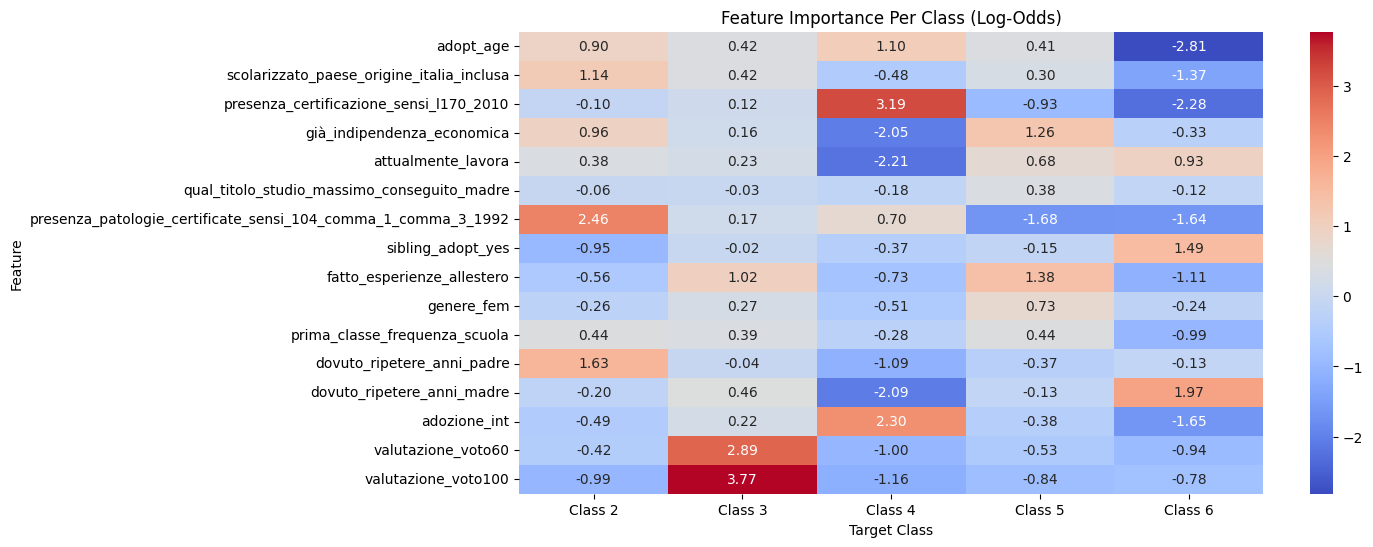

In [49]:
plt.figure(figsize=(12, 6))
sns.heatmap(feature_importance_per_class.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Importance Per Class (Log-Odds)")
plt.xlabel("Target Class")
plt.ylabel("Feature")
plt.show()

In [ ]:
# formula = '''
# qual_titolo_studio_massimo_conseguito ~
#     adopt_age +
#     già_indipendenza_economica +
#     presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 +
#     presenza_certificazione_sensi_l170_2010 +
#     sibling_adopt_yes +
#     genere_fem +
#     dovuto_ripetere_anni_madre +
#     dovuto_ripetere_anni_padre +
#     adozione_int +
#     valutazione_voto100 +
#     adozione_int * presenza_certificazione_sensi_l170_2010
#     -1
# '''

### SEM

In [63]:
!pip install semopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 11.0 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659681 sha256=440cb83e0c86007ce27f3654206feadb0dc962e7b92efcaea88763b6c2044756
  Stored in directory: /root/.cache/pip/wheels/d2/9a/31/fae291ff6a649bad125037eef8c7cc63d8c542e14bdcccea37
Successfully built semopy


In [65]:
from semopy import Model
sem_model_desc = """
qual_titolo_studio_massimo_conseguito ~ adopt_age + scolarizzato_paese_origine_italia_inclusa + presenza_certificazione_sensi_l170_2010 + già_indipendenza_economica + attualmente_lavora + qual_titolo_studio_massimo_conseguito_madre + presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + sibling_adopt_yes + fatto_esperienze_allestero + genere_fem + prima_classe_frequenza_scuola + dovuto_ripetere_anni_padre + dovuto_ripetere_anni_madre + adozione_int + valutazione_voto60 + valutazione_voto100
"""
model = Model(sem_model_desc)
model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,qual_titolo_studio_massimo_conseguito,~,adopt_age,-0.135825,0.070652,-1.922440,0.054550
1,qual_titolo_studio_massimo_conseguito,~,scolarizzato_paese_origine_italia_inclusa,-0.121543,0.133597,-0.909775,0.362941
2,qual_titolo_studio_massimo_conseguito,~,presenza_certificazione_sensi_l170_2010,0.046784,0.130863,0.357508,0.720712
3,qual_titolo_studio_massimo_conseguito,~,già_indipendenza_economica,0.198768,0.140457,1.415146,0.157026
4,qual_titolo_studio_massimo_conseguito,~,attualmente_lavora,-0.014753,0.123275,-0.119677,0.904739
5,qual_titolo_studio_massimo_conseguito,~,qual_titolo_studio_massimo_conseguito_madre,0.032970,0.031699,1.040103,0.298292
6,qual_titolo_studio_massimo_conseguito,~,presenza_patologie_certificate_sensi_104_comma...,-0.539483,0.148612,-3.630138,0.000283
7,qual_titolo_studio_massimo_conseguito,~,sibling_adopt_yes,0.349127,0.109622,3.184812,0.001448
8,qual_titolo_studio_massimo_conseguito,~,fatto_esperienze_allestero,0.322733,0.111228,2.901530,0.003713
9,qual_titolo_studio_massimo_conseguito,~,genere_fem,0.306970,0.094869,3.235717,0.001213


In [76]:
sem_model_desc = """
personal =~ genere_fem + fatto_esperienze_allestero + adozione_int
school =~ valutazione_voto60 + valutazione_voto100 + fatto_esperienze_allestero
family =~ qual_titolo_studio_massimo_conseguito_madre + dovuto_ripetere_anni_madre+sibling_adopt_yes

qual_titolo_studio_massimo_conseguito ~ personal + school + family
qual_titolo_studio_massimo_conseguito ~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992
school ~ personal

school ~~ family
personal ~~ school
school ~~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992
"""
model = Model(sem_model_desc)
model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,school,~,personal,5.090448e-02,13811431.819519,0.0,1.0
1,genere_fem,~,personal,1.000000e+00,-,-,-
2,fatto_esperienze_allestero,~,personal,4.396492e-02,0.080722,0.544649,0.585995
3,fatto_esperienze_allestero,~,school,6.150352e-04,0.022754,0.027029,0.978436
4,adozione_int,~,personal,-2.241388e-01,0.227051,-0.987173,0.323558
5,valutazione_voto60,~,school,1.000000e+00,-,-,-
6,valutazione_voto100,~,school,-2.854555e-01,0.426658,-0.669051,0.503463
7,qual_titolo_studio_massimo_conseguito_madre,~,family,1.000000e+00,-,-,-
8,dovuto_ripetere_anni_madre,~,family,3.540364e-01,0.399807,0.885519,0.375877
9,sibling_adopt_yes,~,family,1.300981e+00,1.370781,0.94908,0.34258


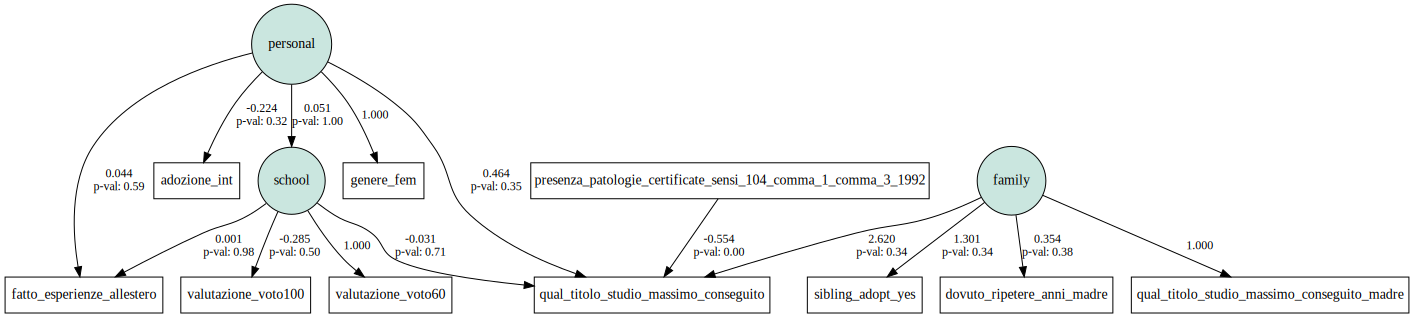

In [77]:
from semopy import calc_stats, semplot

semplot(model, filename='t.pdf')

In [78]:
from semopy import calc_stats

calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,28,46,40.070373,0.065179,143.46403,0.876156,0.720694,0.54114,0.720694,0.796541,0.034042,53.788751,159.671369,0.105624


In [82]:
sem_model_desc = """
personal =~ genere_fem + fatto_esperienze_allestero + adozione_int
school =~ valutazione_voto60 + valutazione_voto100 + fatto_esperienze_allestero
family =~ qual_titolo_studio_massimo_conseguito_madre + dovuto_ripetere_anni_madre+sibling_adopt_yes


qual_titolo_studio_massimo_conseguito ~ personal + school + family
qual_titolo_studio_massimo_conseguito ~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992
school ~ personal

school ~~ family
school ~~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992
"""
model = Model(sem_model_desc)
model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,school,~,personal,0.108141,0.191997,0.563245,0.573268
1,genere_fem,~,personal,1.000000,-,-,-
2,fatto_esperienze_allestero,~,personal,0.045956,0.082715,0.555589,0.578492
3,fatto_esperienze_allestero,~,school,0.000559,0.022754,0.024571,0.980397
4,adozione_int,~,personal,-0.228857,0.227406,-1.006382,0.314232
5,valutazione_voto60,~,school,1.000000,-,-,-
6,valutazione_voto100,~,school,-0.285417,0.426689,-0.66891,0.503553
7,qual_titolo_studio_massimo_conseguito_madre,~,family,1.000000,-,-,-
8,dovuto_ripetere_anni_madre,~,family,0.350571,0.394674,0.888255,0.374404
9,sibling_adopt_yes,~,family,1.290624,1.351948,0.95464,0.33976


In [83]:
calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,29,46,40.069562,0.082806,143.46403,0.886424,0.7207,0.556972,0.7207,0.819845,0.032033,51.788681,153.74972,0.105659


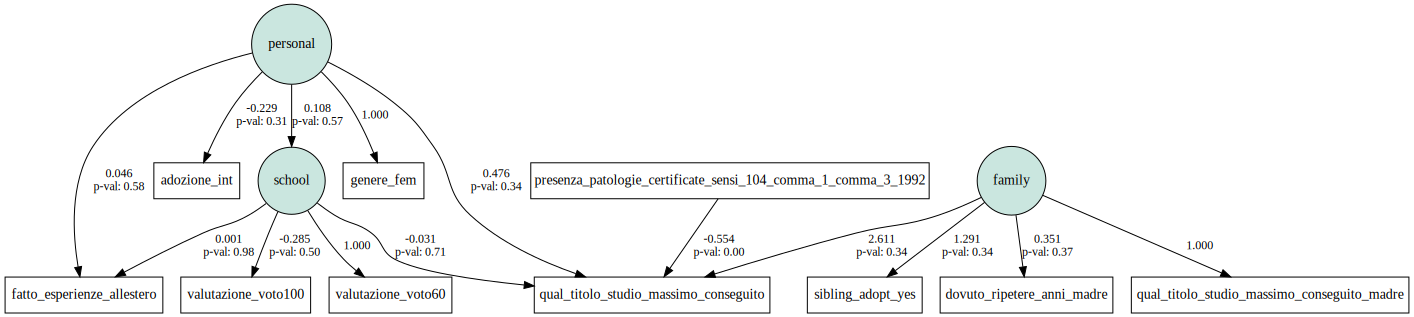

In [84]:
semplot(model, filename='t.pdf')

In [72]:
desc3 = """
# Latent Variables
# First-Level Latent Variables
family_structure =~ sibling_adopt_yes + qual_titolo_studio_massimo_conseguito_madre + dovuto_ripetere_anni_madre + già_indipendenza_economica
personal =~ genere_fem + adopt_age + fatto_esperienze_allestero
cognitive_ability =~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + presenza_certificazione_sensi_l170_2010

personal ~~ family_structure

qual_titolo_studio_massimo_conseguito ~ family_structure + cognitive_ability + personal
"""

model3 = Model(desc3)
model3.fit(resampled_df, obj="DWLS", solver="SLSQP")
model3.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,sibling_adopt_yes,~,family_structure,1.000000e+00,-,-,-
1,qual_titolo_studio_massimo_conseguito_madre,~,family_structure,-1.222065e+01,4.206302,-2.905318,0.003669
2,dovuto_ripetere_anni_madre,~,family_structure,1.863307e+00,0.665614,2.79938,0.00512
3,già_indipendenza_economica,~,family_structure,4.242540e+00,1.453479,2.918886,0.003513
4,genere_fem,~,personal,1.000000e+00,-,-,-
5,adopt_age,~,personal,-9.125568e+00,3.507701,-2.601581,0.00928
6,fatto_esperienze_allestero,~,personal,4.000953e-02,0.260849,0.153382,0.878097
7,presenza_patologie_certificate_sensi_104_comma...,~,cognitive_ability,1.000000e+00,-,-,-
8,presenza_certificazione_sensi_l170_2010,~,cognitive_ability,9.634160e-01,0.147126,6.548237,0.0
9,qual_titolo_studio_massimo_conseguito,~,family_structure,-9.567184e+00,28.853843,-0.331574,0.740211


In [73]:
calc_stats(model3)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,30,45,185.717796,0.0,1032.978232,0.842387,0.820211,0.730317,0.820211,0.763581,0.075859,49.421479,169.564543,0.28926


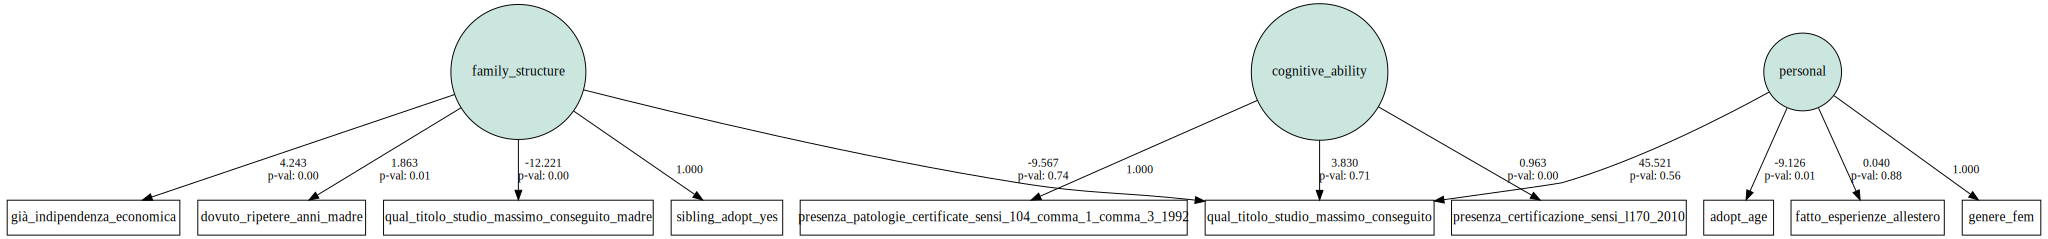

In [74]:
semplot(model3, filename='t.pdf')

In [ ]:
# # Latent Class Analysis
# from sklearn.mixture import GaussianMixture

# lca_vars = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# lca_model = GaussianMixture(n_components=7, covariance_type="diag", random_state=42)
# df_cleaned["Latent_Class"] = lca_model.fit_predict(df_cleaned[lca_vars])
# lca_results = df_cleaned[["Latent_Class"] + list(lca_vars)]
# print("\nLCA Classification Results:\n")
# print(lca_results.head(30))

### Non-Param.

In [50]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [51]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(loss_function='MultiClass',
    iterations=680,
    depth=5,
    learning_rate=0.015,
    l2_leaf_reg=40,
    random_seed=42,
    early_stopping_rounds=18,
    random_strength=2,
    auto_class_weights="Balanced",
    bagging_temperature=1,
    verbose=False,
    eval_metric="TotalF1"   # focus on smaller classes
)

cat_model.fit(X_train, y_train)
y_train_pred_cat = cat_model.predict(X_train)
y_test_pred_cat = cat_model.predict(X_test)


train_accuracy_cat = accuracy_score(y_train, y_train_pred_cat)
test_accuracy_cat = accuracy_score(y_test, y_test_pred_cat)
train_mae_cat = mean_absolute_error(y_train, y_train_pred_cat)
test_mae_cat = mean_absolute_error(y_test, y_test_pred_cat)


conf_matrix_cat = confusion_matrix(y_test, y_test_pred_cat, labels=np.unique(y_test))
class_report_cat = classification_report(
    y_test, y_test_pred_cat, target_names=[f"Class {i}" for i in np.unique(y_test)], zero_division=0
)

print("\nCatBoost Results:")
print("Confusion Matrix:\n", conf_matrix_cat)
print("\nClassification Report:\n", class_report_cat)
print(f"Training Accuracy: {train_accuracy_cat:.4f}")
print(f"Test Accuracy: {test_accuracy_cat:.4f}")
print(f"Training MAE: {train_mae_cat:.4f}")
print(f"Test MAE: {test_mae_cat:.4f}")



CatBoost Results:
Confusion Matrix:
 [[ 9  0  5  2  1]
 [ 1 41  2  1  0]
 [ 1  0  0  1  0]
 [ 0  0  2  6  0]
 [ 0  0  0  2  1]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.82      0.53      0.64        17
     Class 3       1.00      0.91      0.95        45
     Class 4       0.00      0.00      0.00         2
     Class 5       0.50      0.75      0.60         8
     Class 6       0.50      0.33      0.40         3

    accuracy                           0.76        75
   macro avg       0.56      0.50      0.52        75
weighted avg       0.86      0.76      0.80        75

Training Accuracy: 0.8483
Test Accuracy: 0.7600
Training MAE: 0.3610
Test MAE: 0.4267


In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Cross-validation accuracy: 0.8117 ± 0.0220


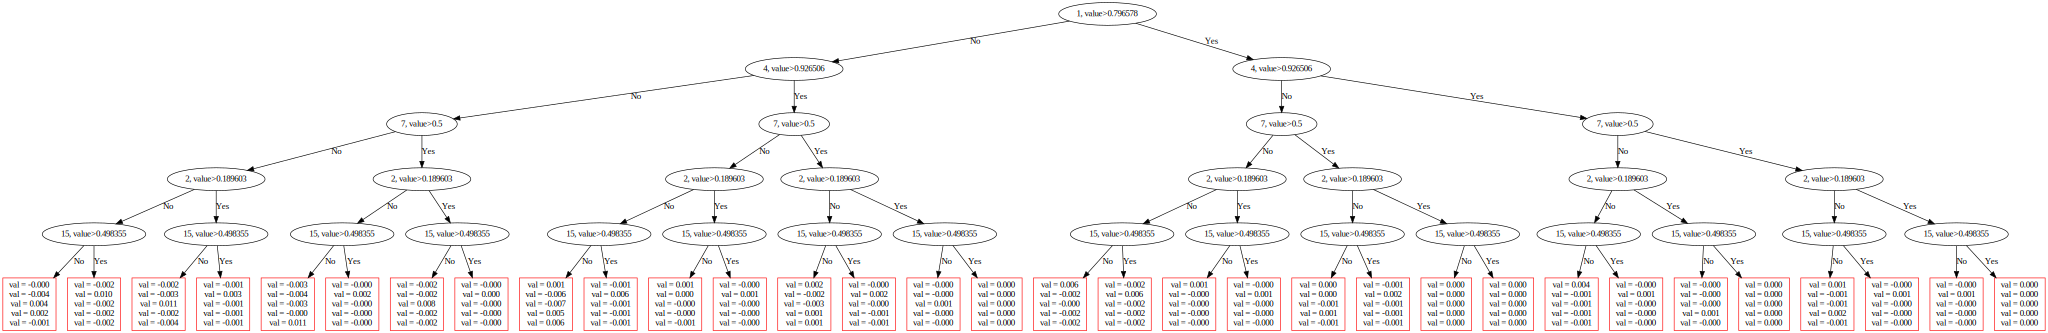

In [53]:
cat_model.plot_tree(
    tree_idx=10)

In [54]:
catboost_features = cat_model.feature_names_
feature_importances = cat_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': catboost_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
15,valutazione_voto100,26.325231
0,adopt_age,15.721457
3,già_indipendenza_economica,7.899194
2,presenza_certificazione_sensi_l170_2010,6.944478
10,prima_classe_frequenza_scuola,6.098450
4,attualmente_lavora,5.949038
5,qual_titolo_studio_massimo_conseguito_madre,5.714993
14,valutazione_voto60,4.122763
1,scolarizzato_paese_origine_italia_inclusa,3.765370
12,dovuto_ripetere_anni_madre,3.736012


In [55]:
pip install shap

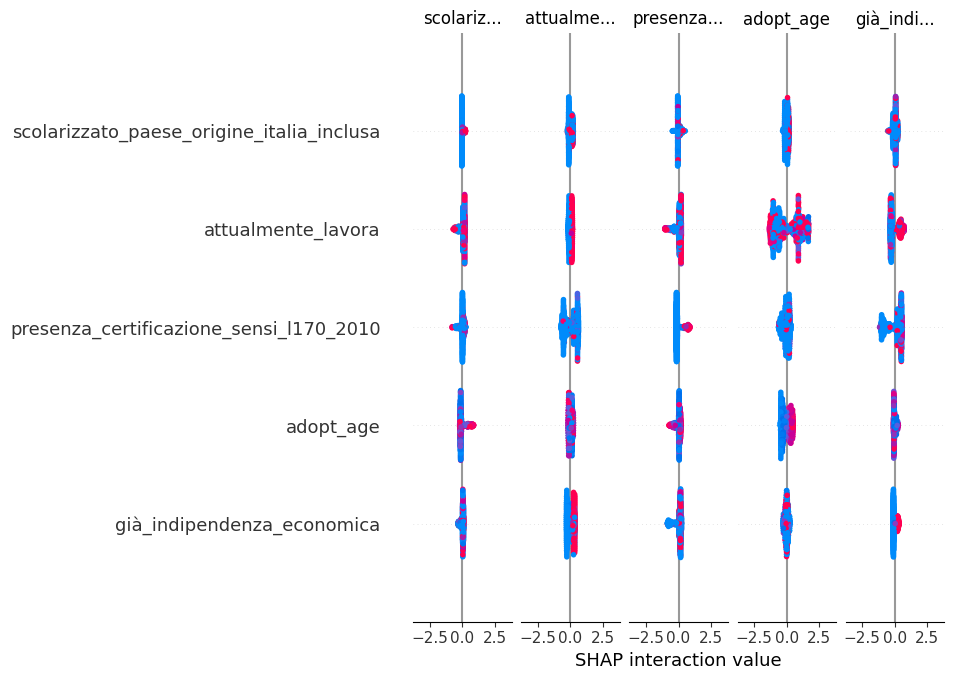

In [57]:
import shap
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
pipeline = Pipeline([
    ('svm', SVC(probability=True, random_state=42))
])
param_grid = [
    {'svm__C': [0.9, 0.95, 0.97], 'svm__kernel': ['linear']},
]

grid_search = GridSearchCV(
    pipeline, param_grid, cv=10, scoring='roc_auc_ovr', refit=True, n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

y_train_proba = best_svm.predict_proba(X_train)
y_test_proba = best_svm.predict_proba(X_test)

train_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovr')
test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
overfitting_gap = abs(train_auc - test_auc)

print(f"\n Final Train ROC AUC: {train_auc:.4f}")
print(f"Final Test ROC AUC: {test_auc:.4f}")
print(f"Overfitting Gap (AUC): {overfitting_gap:.4f}")
print("Best Parameters (Final Tuning):", grid_search.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits

 Final Train ROC AUC: 0.9541
Final Test ROC AUC: 0.8561
Overfitting Gap (AUC): 0.0980
Best Parameters (Final Tuning): {'svm__C': 0.95, 'svm__kernel': 'linear'}


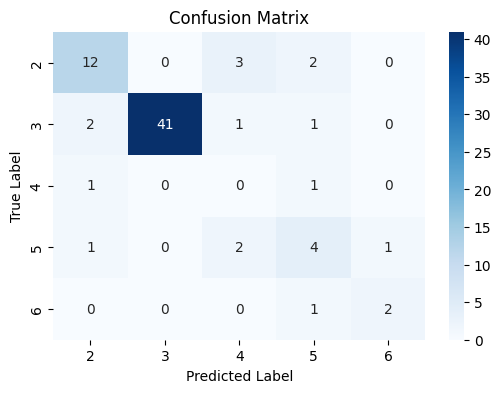

Classification Report:
               precision    recall  f1-score   support

           2       0.75      0.71      0.73        17
           3       1.00      0.91      0.95        45
           4       0.00      0.00      0.00         2
           5       0.44      0.50      0.47         8
           6       0.67      0.67      0.67         3

    accuracy                           0.79        75
   macro avg       0.57      0.56      0.56        75
weighted avg       0.84      0.79      0.81        75



In [61]:
y_test_pred = best_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_test_pred, zero_division=1))

<ipython-input-62-42bc5fc3d7dc>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


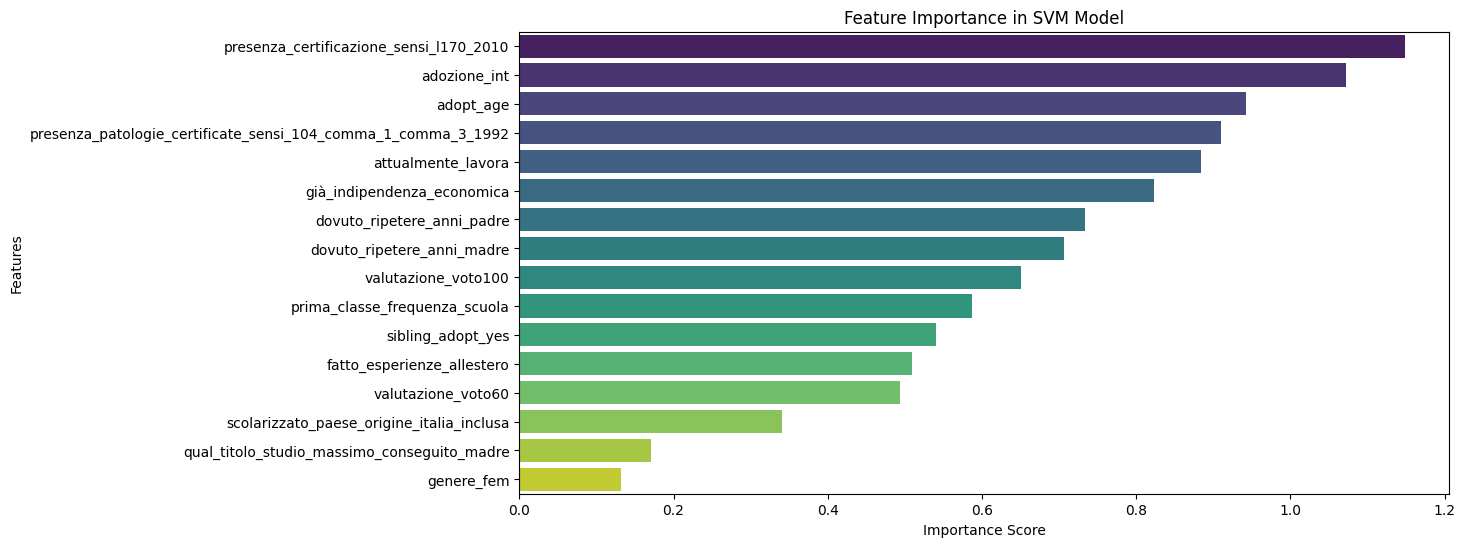

In [62]:
feature_importance = np.abs(best_svm.named_steps['svm'].coef_).mean(axis=0)

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in SVM Model")
plt.show()